### Import the libraries we need

In [1]:
# data imgestion
import requests
from io import BytesIO

# data manipulation
import pandas as pd
import numpy as np

# data modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# data visualization
import matplotlib.pyplot as plt

### Data ingestion
Here we specify the data source, download the data and read it into a DataFrame

In [2]:
url = 'https://introtomlsampledata.blob.core.windows.net/data/bike-rental/bike-rental-hour.csv'
response = requests.get(url)
df = pd.read_csv(BytesIO(response.content))
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Data cleaning
* Set the `season` and `weathersit` columns to categorical
* Remove the `instant`, `dteday`, `casual` and `registered` columns

Let's pause and think for a minute why these steps are being taken.

#### Categorical features

From the first few rows of the data you can see that the `season` and `weathersit` columns are numerical. That's great, isn't it? We like working with numerical data. Well in this case these fields are not meant to be dealt with in a numerical way as the numbers would indicate that one season or one weather type is "more" than another when this is not the case. So we mark these as categorical columns. If you want to review this check back to [Lesson 2 Concept 6](https://classroom.udacity.com/nanodegrees/nd00332/parts/9e5002de-e740-4eb2-aa15-03861fff12fc/modules/ae74a72a-97c1-4306-b55e-708c58118bd2/lessons/8bb9ac45-d2ec-4d22-99e1-d75455c86d9a/concepts/308d916e-91e0-405c-b7c5-26bb94bc73f4) and [Lesson 2 Concept 9](https://classroom.udacity.com/nanodegrees/nd00332/parts/9e5002de-e740-4eb2-aa15-03861fff12fc/modules/ae74a72a-97c1-4306-b55e-708c58118bd2/lessons/8bb9ac45-d2ec-4d22-99e1-d75455c86d9a/concepts/82000bfc-2670-41c8-820b-e8fc6d4cca83).


#### Drop unnecessary or unwanted features

We have many features indicating the timeline, some of which are obviously highly correlated. We should drop the columns `instant` and `dteday`.

The `casual` and `registered` columns just split the count between rental types so they are perfectly correlated with our target variable. We don't want the model to simply learn how to add so we drop those too.

If we were to go further, another example would be that the `atemp` field is a normalized version of `temp` so we should drop `temp` also but this demo did not do that.

In [3]:
dataset = df.drop(columns=['instant','dteday','casual','registered'])
cat_cols = ['weathersit','season']
for col in cat_cols:
    dataset[col] = dataset[col].astype('category')

#### New features
We want to find out whether previous hour total counts are a good indicator of the current hour's total count. To answer this question we need to add in to each hour, new columns that show the total counts for the previous 12 hours. To do this we use the pandas `shift` function. Note that we don't have the previous 12 hours for the first few rows so we need to specify that we want to fill those with `na`.

In [4]:
for i in range(12):
    prev_col_name = 'cnt' if i == 0 else 'Rentals in hour -{}'.format(i)
    new_col_name = 'Rentals in hour -{}'.format(i+1)
    dataset[new_col_name] = dataset[prev_col_name].shift(1).fillna(0)

### Data preparation
We split the data into a training set and a test set and identify the target and feature columns

split the data based on the `yr` column, so we need to remove that column before we train the model.

In [5]:
train_df = dataset[dataset.yr==0].drop(columns='yr')
test_df = dataset[dataset.yr==1].drop(columns='yr')
(train_df.shape, test_df.shape)

((8645, 24), (8734, 24))

In [6]:
# specify our target column
y_col = 'cnt'
# specify our feature columns
X_cols = train_df.drop(columns=y_col).columns.to_list()

In [7]:
# separate the features from the target
train_X, train_y = train_df[X_cols], train_df[[y_col]]
test_X, test_y = test_df[X_cols], test_df[[y_col]]

### Train model
We instantiate the `GradientBoostingRegressor` class from `scikit-learn` and set it up with the same parameters from the lab.

In [8]:
model = GradientBoostingRegressor(
    min_samples_leaf=10, max_leaf_nodes=20,
    n_estimators=100, learning_rate=0.2,
    random_state=0, loss='ls')
model.fit(train_X, train_y.values.ravel())
pred_y = model.predict(test_X)

### Score / evaluate model
Predict values for the test set and compare against the real values

Let's start with the RMSE metric - the standard metric for regression analysis.

Remember that this metric is the square root of the mean of the squared differences between each predicted / true pair.

In [9]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_y, pred_y)**0.5
print(f'Root mean squared error: {rmse:0.2f}')
print(f'i.e. roughly {rmse:0.0f} bicycles')

Root mean squared error: 86.58
i.e. roughly 87 bicycles


Let's think about that number in the context of the average number of bicycles

In [10]:
print(f'Average bicycles: {test_y.values.mean()}')
print(f'So the RMSE is about {(rmse/test_y.values.mean()):0.1%} of the average number of bicycles')

Average bicycles: 234.6663613464621
So the RMSE is about 36.9% of the average number of bicycles


Ouch... the average error in the model is quite large compared to the average number of bicycles!

OK so we already know it's not a great model. Anyway, let's check it out a little more.

How about how well the predicted values correlate to the true values? Let's look at the coefficient of determination, also called the r-squared value.

In [11]:
from sklearn.metrics import r2_score
r2_score(test_y, pred_y)

0.8282139429117988

So it's not too far off a good correlation but let's see how that actually looks when we plot the predicted values against the true values.

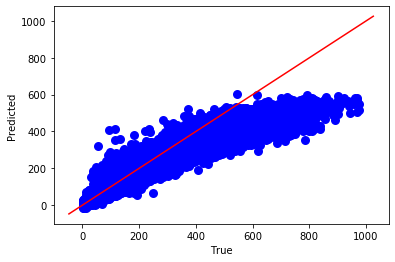

In [12]:
fig, ax = plt.subplots()
ax.scatter(test_y, pred_y, color='blue', linewidth=3)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
# add an accuracy guide
x = np.linspace(*ax.get_xlim(),10)
ax.plot(x,x,c='red')
plt.show()

Clearly the correlation starts off well but the model falters at higher values. Lastly let's take a look at which features are most influential with respect to the predictions.

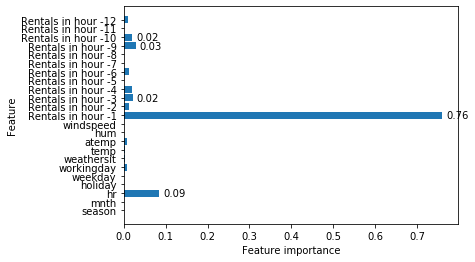

In [13]:
fig, ax = plt.subplots()
ax.barh(
    y=train_X.columns,
    width=model.feature_importances_
)
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature')
spacing = 5
for rect in ax.patches:
    xpos = rect.get_width()
    ypos = rect.get_y() + rect.get_height()/2
    label = f'{xpos:0.2f}' if xpos>0.02 else ''
    ax.annotate(
        label, xy=(xpos,ypos), xytext=(15,-5),
        textcoords='offset points', ha='center', va='bottom'
    )

The vast majority of the calculation is driven by the previous hour's total. This makes total sense. The number of bicycles fluctuates during the day but not wildly, so it's reasonable for the total in one hour to be not too far above or below the total for the previous hour or indeed the next hour.

However let's pause for a minute here. Whether or not this is useful will depend on your real-world application. Why would you need to know the number of bicycles in any particular hour?

* You might want to forecast your revenue in real time
* You might want to check that the actual number matches some expectation
* You might want to plan out how many bikes you need on hand at any time

In the first two scenarios this model may suffice as you would get the previous hour's data in time to make this prediction, however in the last scenario, you wouldn't get the previous hour's total in time to move bikes to where you need them to be to have enough for people to rent. In that case this model would be useless because you wouldn't have the inputs at the time you needed them. The predictions would not be timely.